In [1]:
! pip install --upgrade atlas_schema
! pip install --upgrade --pre mplhep
import mplhep
mplhep.__version__

# import importlib
# importlib.reload(utils)

'1.0.0rc7.dev11+g271a85873'

In [2]:
import gzip
import json
import re
import time

import awkward as ak
import dask
import vector
import hist
import matplotlib.pyplot as plt
import numpy as np
import uproot

from atlas_schema.schema import NtupleSchema
from coffea import processor
from coffea.nanoevents import NanoEventsFactory
from dask.distributed import Client, PipInstall, performance_report


import utils

vector.register_awkward()
mplhep.style.use(mplhep.style.ATLAS1)

client = Client("tls://localhost:8786")

plugin = PipInstall(packages=["atlas_schema"], pip_options=["--upgrade"])
client.register_plugin(plugin)

### fileset preparation

In [3]:
# load metadata from file
fname = "ntuple_production/file_metadata.json.gz"
with gzip.open(fname) as f:
    dataset_info = json.loads(f.read().decode())

# construct fileset
fileset = {}
for containers_for_category in dataset_info.values():
    for container, metadata in containers_for_category.items():
        if metadata["files_output"] is None:
            # print(f"skipping missing {container}")
            continue

        dsid, _, campaign = utils.dsid_rtag_campaign(container)

        # debugging shortcuts
        # if campaign not in ["mc20a", "data15", "data16"]: continue
        # if "601352" not in dsid: continue

        weight_xs = utils.sample_xs(campaign, dsid)
        lumi = utils.integrated_luminosity(campaign)
        fileset[container] = {"files": dict((path, "reco") for path in metadata["files_output"]), "metadata": {"dsid": dsid, "campaign": campaign, "weight_xs": weight_xs, "lumi": lumi}}

# minimal fileset for debugging
# fileset = {"mc20_13TeV.601352.PhPy8EG_tW_dyn_DR_incl_antitop.deriv.DAOD_PHYSLITE.e8547_s4231_r13144_p6697": fileset["mc20_13TeV.601352.PhPy8EG_tW_dyn_DR_incl_antitop.deriv.DAOD_PHYSLITE.e8547_s4231_r13144_p6697"]}
# fileset

### simple non-distributed reading

/usr/local/lib/python3.12/site-packages/atlas_schema/schema.py:175: RuntimeWarning: Missing event_ids : ['lumiBlock', 'mcEventWeights', 'dataTakingYear']
  self._build_collections(self._form["fields"], self._form["contents"])
/usr/local/lib/python3.12/site-packages/atlas_schema/schema.py:175: RuntimeWarning: I found a collection with no defined mixin: 'globalTriggerEffSF'. I will assume behavior: 'NanoCollection'. To suppress this warning next time, please define mixins for your custom collections. [mixin-undefined]
  self._build_collections(self._form["fields"], self._form["contents"])
/usr/local/lib/python3.12/site-packages/atlas_schema/schema.py:175: RuntimeWarning: I found a collection with no defined mixin: 'globalTriggerMatch'. I will assume behavior: 'Systematic'. To suppress this warning next time, please define mixins for your custom collections. [mixin-undefined]
  self._build_collections(self._form["fields"], self._form["contents"])


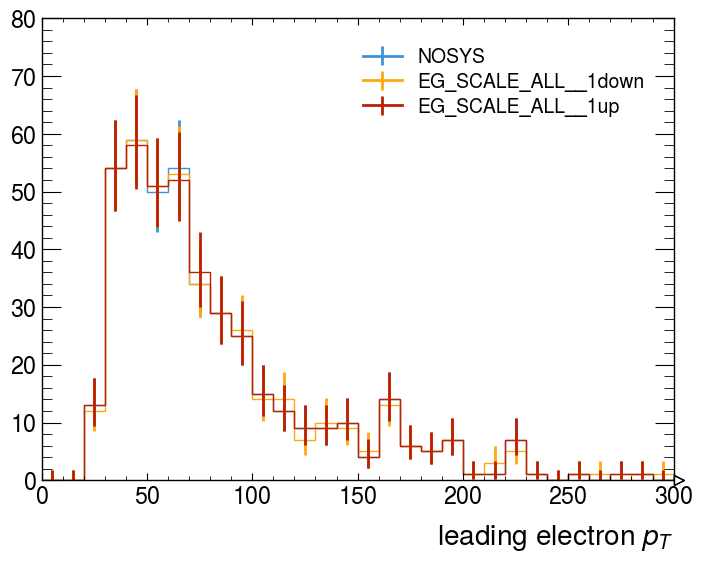

In [4]:
events = NanoEventsFactory.from_root(
    {list(fileset[list(fileset.keys())[0]]["files"])[0]: "reco"},
    mode="virtual",
    schemaclass=NtupleSchema,
    entry_stop=1000
).events()

h = hist.new.Regular(30, 0, 300, label="leading electron $p_T$").StrCat([], name="variation", growth=True).Weight()

for variation in events.systematic_names:
    if variation != "NOSYS" and "EG_SCALE_ALL" not in variation:
        continue

    cut = events[variation]["pass"]["ejets"] == 1
    h.fill(events[variation][cut==1].el.pt[:, 0] / 1_000, variation=variation)

fig, ax = plt.subplots()
for variation in h.axes[1]:
    h[:, variation].plot(histtype="step", label=variation, ax=ax)
_ = ax.legend()

### pre-processing

In [ ]:
run = processor.Runner(
    executor = processor.DaskExecutor(client=client),
    # executor = processor.IterativeExecutor(),
    schema=NtupleSchema,
    savemetrics=True,
    chunksize=200_000,
    skipbadfiles=True,
    # maxchunks=1
)

with performance_report(filename="preprocess.html"):
    preprocess_output = run.preprocess(fileset)

# write to disk
with open("preprocess_output.json", "w") as f:
    json.dump(utils.preprocess_to_json(preprocess_output), f)

# load from disk
with open("preprocess_output.json") as f:
    preprocess_output = utils.json_to_preprocess(json.load(f))

len(preprocess_output), preprocess_output[:3]

[##                                      ] | 5% Completed |  1min 27.1s

### processing

In [ ]:
class Analysis(processor.ProcessorABC):
    def __init__(self):
        self.h = hist.new.Regular(30, 0, 300, label="leading electron $p_T$").\
            StrCat([], name="dsid_and_campaign", growth=True).\
            StrCat([], name="variation", growth=True).\
            Weight()

    def process(self, events):
        f = uproot.open(events.metadata["filename"])

        # this should match existing pre-determined metadata
        # sim_type, mc_campaign, dsid, etag = f["metadata"].axes[0]
        # assert mc_campaign == events.metadata["campaign"]
        # assert dsid == events.metadata["dsid"]

        # ensure systematics in schema and in histogram match
        # systematics_from_hist = list(f["listOfSystematics"].axes[0])
        # assert sorted(systematics_from_hist) == sorted(events.systematic_names)

        # categorize events by DSID and campaign with a single histogram axis
        dsid_and_campaign = f"{events.metadata["dsid"]}_{events.metadata["campaign"]}"

        if events.metadata["dsid"] != "data":
            sumw = float(f[f.keys(filter_name="CutBookkeeper*NOSYS")[0]].values()[1])  # initial sum of weights
        else:
            sumw = None  # no normalization for data

        for variation in events.systematic_names:
            if variation != "NOSYS" and "EG_SCALE_ALL" not in variation:
                continue

            cut = events[variation]["pass"]["ejets"] == 1
            weight = (events[variation][cut==1].weight.mc if events.metadata["dsid"] != "data" else 1.0) * events.metadata["weight_xs"] * events.metadata["lumi"]
            self.h.fill(events[variation][cut==1].el.pt[:, 0] / 1_000, dsid_and_campaign=dsid_and_campaign, variation=variation, weight=weight)

        return {
            "hist": self.h,
            "meta": {
                "sumw": {(events.metadata["dsid"], events.metadata["campaign"]): {(events.metadata["fileuuid"], sumw)}}}  # sumw in a set to avoid summing multiple times per file
        }

    def postprocess(self, accumulator):
        # normalize histograms
        # https://topcptoolkit.docs.cern.ch/latest/starting/running_local/#sum-of-weights
        for dsid_and_campaign in accumulator["hist"].axes[1]:
            dsid, campaign = dsid_and_campaign.split("_")
            if dsid == "data":
                continue  # no normalization for data by total number of weighted events
            norm = 1 / sum([sumw for uuid, sumw in accumulator["meta"]["sumw"][(dsid, campaign)]])
            count_normalized = accumulator["hist"][:, dsid_and_campaign, :].values()*norm
            variance_normalized = accumulator["hist"][:, dsid_and_campaign, :].variances()*norm**2
            accumulator["hist"][:, dsid_and_campaign, :] = np.stack([count_normalized, variance_normalized], axis=-1)


t0 = time.perf_counter()
with performance_report(filename="process.html"):
    out, report = run(preprocess_output, processor_instance=Analysis())
t1 = time.perf_counter()
report

track XCache egress: [link](https://grafana.mwt2.org/d/EKefjM-Sz/af-network-200gbps-challenge?var-cnode=c111_af_uchicago_edu&var-cnode=c112_af_uchicago_edu&var-cnode=c113_af_uchicago_edu&var-cnode=c114_af_uchicago_edu&var-cnode=c115_af_uchicago_edu&viewPanel=195&kiosk=true&orgId=1&from=now-1h&to=now&timezone=browser&refresh=5s)

In [ ]:
print(f"data read: {report["bytesread"] / 1000**3:.2f} GB in {report["chunks"]} chunks")

print(f"core-average event rate using \'processtime\': {report["entries"] / 1000 / report["processtime"]:.2f} kHz")
print(f"core-average data rate using \'processtime\': {report["bytesread"] / 1000**3 * 8 / report["processtime"]:.2f} Gbps")

print(f"average event rate using walltime: {report["entries"] / 1000 / (t1 - t0):.2f} kHz")
print(f"average data rate using walltime: {report["bytesread"] / 1000**3 * 8 / (t1 - t0):.2f} Gbps")

In [ ]:
mc_stack = []
labels = []
for key in dataset_info:
    dsids = []
    for container in dataset_info[key]:
        dsids.append(container.split(".")[1])

    dsids = sorted(set(dsids))
    dsids_in_hist = [dc for dc in out["hist"].axes[1] if dc.split("_")[0] in dsids]
    # print(f"{key}:\n  - expect {dsids}\n  - have {dsids_in_hist}")

    if key in ["data", "ttbar_H7", "ttbar_hdamp", "ttbar_pthard", "Wt_DS", "Wt_H7", "Wt_pthard"] or len(dsids_in_hist) == 0:
        continue  # data drawn separately, skip MC modeling variations and skip empty categories

    mc_stack.append(out["hist"][:, :, "NOSYS"].integrate("dsid_and_campaign", dsids_in_hist))
    labels.append(key)

try:
    data_hist = out["hist"].integrate("dsid_and_campaign", [dc for dc in out["hist"].axes[1] if "data" in dc])[:, "NOSYS"]
except ValueError:
    print("falling back to plotting first entry of categorical axes as \"data\"")
    data_hist = out["hist"][:, 0, 0]

fig, ax1, ax2 = mplhep.comp.data_model(
    data_hist=data_hist,
    stacked_components=mc_stack,
    stacked_labels=labels,
    # https://scikit-hep.org/mplhep/gallery/model_with_stacked_and_unstacked_histograms_components/
    # unstacked_components=[],
    # unstacked_labels=[],
    xlabel=out["hist"].axes[0].label,
    ylabel="Entries",
)

mplhep.atlas.label("Internal", ax=ax1, data=True, lumi=f"{utils.integrated_luminosity("", total=True) / 1000:.0f}", com="13/ \\ 13.6 \\ TeV")
mplhep.mpl_magic(ax=ax1)
ax2.set_ylim([0.5, 1.5])

# compare to e.g. https://atlas.web.cern.ch/Atlas/GROUPS/PHYSICS/PAPERS/HDBS-2020-11/fig_02a.png
fig.savefig("el_pt.png")

In [ ]:
# save to disk
import uhi.io.json

with gzip.open("hist.json.gz", "w") as f:
    f.write(json.dumps(out["hist"], default=uhi.io.json.default).encode("utf-8"))

with gzip.open("hist.json.gz") as f:
    h = hist.Hist(json.loads(f.read(), object_hook=uhi.io.json.object_hook))

## ServiceX
### Producing similar histograms from signal samples in the Physlite format

In [ ]:
from servicex import deliver, query 
from servicex_analysis_utils import to_awk, ds_type_resolver

#### Preparing signal containers

In [ ]:
total_sig=0
signal_containers={}
for container, metadata in dataset_info["Hplus_cb"].items():
    total_sig+=metadata["nevts_input"]
    mass = utils.hplus_signal_mass(container)
    _ , _, campaign = utils.dsid_rtag_campaign(container)
    signal_containers[f"{mass}_{campaign}"]=container
print(f"H+ -> cb signal in {len(signal_containers)} DSIDs for {total_sig:.0e} total events")

#### Building the trasnformation query

In [ ]:
selection = (
    "(sum(AnalysisJetsAuxDyn.pt > 25000, axis=1) > 3)"                          # at least 4 jets
    " & (any(AnalysisElectronsAuxDyn.pt > 25000, axis=1))"                      # at least 1 electron
    " & (any(log("
    "       BTagging_AntiKt4EMPFlowAuxDyn.GN2v01_pb / "
    "       (0.2*BTagging_AntiKt4EMPFlowAuxDyn.GN2v01_pc + 0.8*BTagging_AntiKt4EMPFlowAuxDyn.GN2v01_pu + 1e-12)"
    "     ) > 2.09, axis=1))"                                                # at least 1 btag
)

In [ ]:
query_up = query.UprootRaw(
    [
        {
            "treename": "CollectionTree",
            "filter_name": ['AnalysisElectronsAuxDyn.pt'],
            "cut": selection
        },
    ]
)

In [ ]:
def build_spec(containers, query_c_cut, name_prefix="Hplus_cb"):
    samples = []
    for label, dsid in containers.items():
        samples.append({
            "Name": label,
            "Dataset": ds_type_resolver(dsid),
            "Query": query_c_cut,
        })
    return {"General": {"Delivery": "LocalCache"}, "Sample": samples}


In [ ]:
transformation_request = build_spec(signal_containers, query_up)

#### Sending the request to the backend

In [ ]:
result_files = deliver(transformation_request, fail_if_incomplete=False, ignore_local_cache=True)

#### Handling the results

In [ ]:
#Load data into arrays
arrays=to_awk(result_files)

In [ ]:
var_key   = "AnalysisElectronsAuxDyn.pt"
xlabel    = r"Electron $p_T$ [GeV]"
bins      = np.linspace(0, 300, 31)   # 10 GeV bins
normalize = False

mplhep.style.use("ATLAS")

hists = {}
edges = None

for name, arr in arrays.items():
    # keep only electrons with pt > 25 GeV (25000 MeV)
    mask = arr[var_key] > 25_000
    x = ak.to_numpy(ak.ravel(arr[var_key][mask])) / 1000.0  # GeV
    y, edges = np.histogram(x, bins=bins)
    if normalize and y.sum() > 0:
        y = y / y.sum()
    hists[name] = y.astype(float)

fig, ax = plt.subplots(figsize=(8, 5.5))
for name, y in hists.items():
    mplhep.histplot(y, bins=edges, ax=ax, histtype="step", label=name, linewidth=1.6)

ax.set_xlabel(xlabel)
ax.set_ylabel("Arbitrary units" if normalize else "Entries")
ax.set_xlim(bins[0], bins[-1])
ax.legend(title="Signal", ncol=3, fontsize=10)
mplhep.atlas.label("Internal", ax=ax, data=False, com="13/ 13.6 TeV")

plt.tight_layout()
plt.show()


### Using servicex to fetch ntuples with only necessary systematics for Coffea

In [ ]:
#needed_branches=report["columns"]
needed_branches = [
    'el_isol_effSF_tight_EG_SCALE_ALL__1down',
    'weight_mc_NOSYS',
    'el_isol_effSF_tight_EG_SCALE_ALL__1up',
    'el_isol_effSF_tight_NOSYS',
    'pass_ejets_EG_SCALE_ALL__1down',
    'el_pt_EG_SCALE_ALL__1down',
    'pass_ejets_NOSYS',
    'pass_ejets_EG_SCALE_ALL__1up',
    'el_e_NOSYS',
    'el_pt_EG_SCALE_ALL__1up',
    'el_pt_NOSYS'
]

In [ ]:
#1) signal with systematics (old version of ntuplizer) 
rucio_did="user.acordeir:nominal_trig_overlap_obj_dump_sys_zprime3k.root"

#2) Write transformation
ds_query = query.UprootRaw(
    [
        {
            "treename": "reco",
            "filter_name": needed_branches, 
            "cut": "num(el_pt_NOSYS)>0",
        }
    ]
)

#3) Write deliver config
spec = {
    "Sample": [{"Name": "zprime", "Dataset": ds_type_resolver(rucio_did), "Query": ds_query}],
}

#4) Get the data 
delivered_file = deliver(spec, ignore_local_cache=True)

In [ ]:
events = NanoEventsFactory.from_root(
    {delivered_file["zprime"][0]: "reco"},
    mode="virtual",
    schemaclass=NtupleSchema,
    entry_stop=1000
).events()

events.systematic_names


In [ ]:
h = hist.new.Regular(30, 0, 300, label="leading electron $p_T$").StrCat([], name="variation", growth=True).Weight()

for variation in events.systematic_names:
    if variation != "NOSYS" and "EG_SCALE_ALL" not in variation:
        continue

    cut = events[variation]["pass"]["ejets"] == 1
    h.fill(events[variation][cut==1].el.pt[:, 0] / 1_000, variation=variation)

fig, ax = plt.subplots()
for variation in h.axes[1]:
    h[:, variation].plot(histtype="step", label=variation, ax=ax)
_ = ax.legend()